1- Importación de librerías

In [ ]:
import os 
import time
import shutil
import pathlib
import itertools

import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint

import warnings
warnings.filterwarnings("ignore")

print('Importaciones realizadas con exito')


Importaciones realizadas con exito


In [2]:
#Valido el estado activo de mi GPU para el procesamiento del modelo (tensorflow- GPU)

import tensorflow as tf

try:
    if tf.test.gpu_device_name():
        physical_devices = tf.config.experimental.list_physical_devices('GPU')
        print('GPU active! -', physical_devices)
    else:
        print('GPU not active!')
except Exception as e:
    print('An error occurred while checking the GPU:', e)

GPU active! - [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
#Valido que las rutas de las carpetas existan y  sean accesibles. ( permisos de escritura )
path_archivos = '../Datasets/Data set seleccionado'

if os.path.exists(path_archivos):
    print(f"La ruta {path_archivos} existe.")
else:
    print(f"La ruta {path_archivos} no existe.")

print(path_archivos)

La ruta ../Datasets/Data set seleccionado existe.
../Datasets/Data set seleccionado


2 - Defino funcionalidades

In [ ]:
# 1- Funcion para la carga de ubicacion de imagenes + etiqueta de clasificacion.

def ubicar_imagenes(path_archivos):
    list_path_imagenes = []
    list_etiquetas_imagenes = []
    list_archivos_clasificacion = os.listdir(path_archivos)
    
    for archivo_clasificacion in list_archivos_clasificacion: #recorro carpeta de clasificación
        path_archivo_clasificacion = os.path.join(path_archivos, archivo_clasificacion)
        lista_imagenes = os.listdir(path_archivo_clasificacion)
        for imagen in lista_imagenes: #recorro imagenes por carpeta
            ubicacion_imagen = os.path.join(path_archivo_clasificacion, imagen)
            list_path_imagenes.append(ubicacion_imagen)
            list_etiquetas_imagenes.append(archivo_clasificacion)

    return list_path_imagenes, list_etiquetas_imagenes


In [ ]:
# 2- Función que concatena dos listas (ruta de imagen con etiqueta) en un dataframe / marco de datos. ( Podriamos ejemplificarlo como una matriz estructurada con indice, columnas y datos)

def generar_dataFrame(list_path_imagenes, list_etiquetas_imagenes):
    Img_series = pd.Series(list_path_imagenes, name= 'path_imagenes') # se convierte en una serie de pandas que contiene todas las rutas de las imágenes.
    Etiq_series = pd.Series(list_etiquetas_imagenes, name='etiquetas') # se convierte en una serie de pandas que contiene las etiquetas a cada imagen
    return pd.concat([Img_series, Etiq_series], axis= 1) #axis=1, crea un DataFrame que tiene dos columnas


In [ ]:
# 3 - Realizo el split de datos para Entrenamiento-Validación y Prueba. Funcionalidad de Sklearn (train_test_split) bajo DataFrames 

def split_datos(path_archivos):
    path_imagenes, etiquetas_imagenes = ubicar_imagenes(path_archivos)
    df = generar_dataFrame(path_imagenes, etiquetas_imagenes)
    estratificacion = df['etiquetas']
    entrenamiento_df, temporal_df = train_test_split(df, 
                                                    train_size=0.8,
                                                    shuffle=True,
                                                    random_state=123,
                                                    stratify=estratificacion
                                                    )

    estratificacion = temporal_df['etiquetas']
    validacion_df, prueba_df = train_test_split(temporal_df,  
                                                train_size=0.5, 
                                                shuffle=True, 
                                                random_state=123, 
                                                stratify=estratificacion
                                                )

    return entrenamiento_df, validacion_df, prueba_df


In [ ]:
# 4- La función se encarga de crear generadores de datos que alimentarán las imágenes al modelo durante el entrenamiento, la validación y la prueba. 
# Los generadores convierten las imágenes en tensores, que son la forma en que los modelos de machine learning procesan datos. ( Librerias de tensorflow en este caso)

def crear_generadores(entrenamiento_df, validacion_df, prueba_df, tamaño_batch):

    tamaño_img = (256, 256)
    canal_img = 3
    color = 'rgb'
    forma_img = (tamaño_img[0], tamaño_img[1], canal_img)

    tamaño_prueba_df = len(prueba_df)
    test_tamaño_batch = max(sorted([tamaño_prueba_df // n for n in range(1, tamaño_prueba_df + 1) 
                                    if tamaño_prueba_df % n == 0 and tamaño_prueba_df / n <= 80]))
    test_cant_iteraciones = tamaño_prueba_df // test_tamaño_batch

    def scalar(img):
        return img

    training_gen = ImageDataGenerator(
        preprocessing_function=scalar,
        horizontal_flip=True
    )
    
    testing_gen = ImageDataGenerator(
        preprocessing_function=scalar
    )

    train_gen = training_gen.flow_from_dataframe(
        entrenamiento_df,
        x_col='path_imagenes',
        y_col='etiquetas',
        target_size=tamaño_img,
        class_mode='categorical',
        color_mode=color,
        shuffle=True,
        batch_size=tamaño_batch
    )

    valid_gen = testing_gen.flow_from_dataframe(
        validacion_df,
        x_col='path_imagenes',
        y_col='etiquetas',
        target_size=tamaño_img,
        class_mode='categorical',
        color_mode=color,
        shuffle=True,
        batch_size=tamaño_batch
    )

    test_gen = testing_gen.flow_from_dataframe(
        prueba_df,
        x_col='path_imagenes',
        y_col='etiquetas',
        target_size=tamaño_img,
        class_mode='categorical',
        color_mode=color,
        shuffle=False,
        batch_size=test_tamaño_batch
    )
    
    return train_gen, valid_gen, test_gen




In [ ]:
# 5 - Esta función toma el generador de datos como entrada y muestra una muestra de las imágenes que genera junto con sus etiquetas (clases).

def visualizar_imagenes(dato_generador):
    gen_diccionario = dato_generador.class_indices
    clases = list(gen_diccionario.keys())
    imagenes, etiquetas = next(dato_generador)

    cant_img_x_lote = len(etiquetas)
    muestra = min(cant_img_x_lote, 25)

    plt.figure(figsize=(20, 20))

    for i in range(muestra):
        plt.subplot(5, 5, i + 1)
        image = imagenes[i] / 255
        plt.imshow(image)
        index = np.argmax(etiquetas[i])
        class_name = clases[index]
        plt.title(class_name, color='blue', fontsize=12)
        plt.axis('off')

    plt.show()


In [ ]:
#Liberar la Memoria de la GPU:
tf.keras.backend.clear_session()

In [ ]:
# 6 - Definicion de callbacks de Keras


class MyCallback(tf.keras.callbacks.Callback):
    def __init__(self, model, patience, stop_patience, threshold, factor, batches, epochs, ask_epoch, save_path=None):
        super(MyCallback, self).__init__()
        self.model = model
        self.patience = patience
        self.stop_patience = stop_patience
        self.threshold = threshold
        self.factor = factor
        self.batches = batches
        self.epochs = epochs
        self.ask_epoch = ask_epoch
        self.save_path = save_path
        self.count = 0
        self.stop_count = 0
        self.best_epoch = 1
        self.initial_lr = float(tf.keras.backend.get_value(model.optimizer.lr))
        self.highest_tracc = 0.0
        self.lowest_vloss = np.inf
        self.best_weights = self.model.get_weights()
        self.initial_weights = self.model.get_weights()
        self.ask_permission = 0

    def on_train_begin(self, logs=None):
        msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor', '% Improv', 'Duration')
        print(msg)
        self.start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        stop_time = time.time()
        tr_duration = stop_time - self.start_time
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))
        msg = f' La duración del tiempo fue {str(hours)} horas, {minutes:4.1f} minutos, {seconds:4.2f} segundos)'
        print(msg)
        self.model.set_weights(self.best_weights)

    def on_train_batch_end(self, batch, logs=None):
        acc = logs.get('accuracy') * 100
        loss = logs.get('loss')
        msg = '{0:20s}processing batch {1:} of {2:5s}-   accuracy=  {3:5.3f}   -   loss: {4:8.5f}'.format(' ', str(batch), str(self.batches), acc, loss)
        print(msg, '\r', end='')

    def on_epoch_begin(self, epoch, logs=None):
        self.ep_start = time.time()

    def on_epoch_end(self, epoch, logs=None):
        ep_end = time.time()
        duration = ep_end - self.ep_start
        lr = float(tf.keras.backend.get_value(self.model.optimizer.lr))
        current_lr = lr
        acc = logs.get('accuracy')
        v_acc = logs.get('val_accuracy')
        loss = logs.get('loss')
        v_loss = logs.get('val_loss')

        if acc < self.threshold:
            monitor = 'accuracy'
            if epoch == 0:
                pimprov = 0.0
            else:
                pimprov = (acc - self.highest_tracc) * 100 / self.highest_tracc

            if acc > self.highest_tracc:
                self.highest_tracc = acc
                self.best_weights = self.model.get_weights()
                self.count = 0
                self.stop_count = 0
                if v_loss < self.lowest_vloss:
                    self.lowest_vloss = v_loss
                self.best_epoch = epoch + 1
            else:
                if self.count >= self.patience - 1:
                    lr = lr * self.factor
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr)
                    self.count = 0
                    self.stop_count += 1
                    if v_loss < self.lowest_vloss:
                        self.lowest_vloss = v_loss
                else:
                    self.count += 1
        else:
            monitor = 'val_loss'
            if epoch == 0:
                pimprov = 0.0
            else:
                pimprov = (self.lowest_vloss - v_loss) * 100 / self.lowest_vloss
            if v_loss < self.lowest_vloss:
                self.lowest_vloss = v_loss
                self.best_weights = self.model.get_weights()
                self.count = 0
                self.stop_count = 0
                self.best_epoch = epoch + 1
            else:
                if self.count >= self.patience - 1:
                    lr = lr * self.factor
                    self.stop_count += 1
                    self.count = 0
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr)
                else:
                    self.count += 1

                if acc > self.highest_tracc:
                    self.highest_tracc = acc

        msg = f'{str(epoch + 1):^3s}/{str(self.epochs):4s} {loss:^9.3f}{acc * 100:^9.3f}{v_loss:^9.5f}{v_acc * 100:^9.3f}{current_lr:^9.5f}{lr:^9.5f}{monitor:^11s}{pimprov:^10.2f}{duration:^8.2f}'
        print(msg)

        if self.stop_count > self.stop_patience - 1:
            msg = f' El entrenamiento se ha detenido en la época {epoch + 1} después de {self.stop_patience}  ajustes de la tasa de aprendizaje sin ninguna mejora.'
            print(msg)
            self.model.stop_training = True
        else:
            if self.ask_epoch != None and self.ask_permission != 0:
                if epoch + 1 >= self.ask_epoch:
                    msg = 'Ingrese H para detener el entrenamiento o un número entero para el número de épocas a ejecutar y luego vuelva a preguntar.'
                    print(msg)
                    ans = input('')
                    if ans == 'H' or ans == 'h':
                        msg = f'El entrenamiento se ha detenido en la época  {epoch + 1} debido a la entrada del usuario'
                        print(msg)
                        self.model.stop_training = True
                    else:
                        try:
                            ans = int(ans)
                            self.ask_epoch += ans
                            msg = f' El entrenamiento continuará hasta la época {str(self.ask_epoch)}'
                            print(msg)
                            msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor', '% Improv', 'Duration')
                            print(msg)
                        except ValueError:
                            msg = 'Ingrese un entero válido o H para detener el entrenamiento'
                            print(msg)


In [ ]:
# Por problemas en el intento de guardado ..se genero una clase extra

def checkpoint_callback():
    checkpoint_dir = './checkpoints' 
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)
    
    checkpoint_filepath = os.path.join(checkpoint_dir, 'model_checkpoint')
    
    model_checkpoint_callback = ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=False,
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
    
    return model_checkpoint_callback

checkpoint_cb = checkpoint_callback()


In [ ]:
# 7- Visualización de resultado del modelo; toma el historial de entrenamiento de un modelo de aprendizaje profundo y genera dos gráficos: uno para la pérdida (loss) y otro para la precisión (accuracy), tanto para el conjunto de entrenamiento como para el conjunto de validación.
def plot_training(hist):
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    Epochs = [i + 1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    plt.figure(figsize=(20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label='Training loss')
    plt.plot(Epochs, val_loss, 'g', label='Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
    plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()



In [ ]:
# 8- Funcion de definición de la matriz confusión
def plot_confusion_matrix(cm, classes, normalize=False, title='Matriz de confusión', cmap=plt.cm.Blues):
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Matriz de confusión normalizada')
    else:
        print('Matriz de confusión, sin Normalization')

    print(cm)

    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')


Ejecución del sistema

1- Visualizo los datos a trabajar

Inicio de la búsqueda de fotos en la carpeta 'Data set seleccionado'.
Hay 1359 imágenes en la carpeta ' Deterioro cognitivo ( CI ) ' .
Hay 898 imágenes en la carpeta ' Deterioro moderado - severo ( AD ) ' .
Hay 939 imágenes en la carpeta ' No deterioro ( CN ) ' .
Búsqueda finalizada


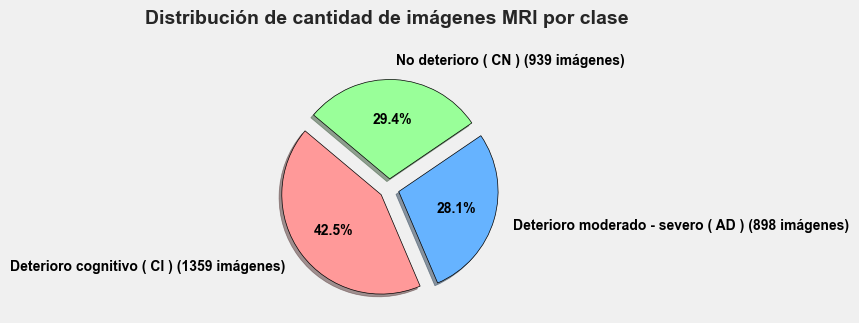

In [64]:
# Realizo un grafico de torta
colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']
class_dist = {}

def contador_imagenes(folder_path):
    basename = os.path.basename(folder_path)
    print('\033[92m'+f"Inicio de la búsqueda de fotos en la carpeta '{basename}'."+'\033[0m')
    image_extensions = ['.jpg', '.jpeg', '.png']

    for root, dirs, _ in os.walk(folder_path):
        for dir_name in dirs:
            dir_path = os.path.join(root, dir_name)
            count = 0

            for filename in os.listdir(dir_path):
                file_ext = os.path.splitext(filename)[1].lower()

                if file_ext in image_extensions:
                    count += 1
            
            class_dist[dir_name] = count
            print(f"Hay \033[35m{count}\033[0m imágenes en la carpeta ' {dir_name} ' .")
    
    print('\033[92m'+"Búsqueda finalizada"+'\033[0m')
    
    # Desarrollo gráfico de torta
    keys = list(class_dist.keys())
    values = list(class_dist.values())
    explode = (0.1,) * len(keys)  # Explosión para cada porción

    labels = [f'{key} ({value} imágenes)' for key, value in zip(keys, values)]

    plt.figure(figsize=(8, 8))  # Ajusta el tamaño del gráfico

    # Definición de función personalizada para autopct
    def autopct_format(values):
        def my_autopct(pct):
            total = sum(values)
            val = int(round(pct * total / 100.0))
            # Forzar a mostrar incluso porcentajes muy pequeños
            return '{:.1f}%'.format(pct) if pct > 0 else ''  
        return my_autopct

    #colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']

    # Crear el gráfico de torta
    plt.pie(
        values, 
        explode=explode, 
        labels=labels, 
        autopct=autopct_format(values), 
        shadow=True, 
        startangle=140,  # Cambiar el ángulo de inicio para mejor distribución
        colors=colors, 
        textprops={
            'fontsize': 10,  # Ajustar el tamaño de la fuente
            'fontweight': 'bold', 
            'color': 'black'
        },  
        wedgeprops={'edgecolor': 'black'}, 
        labeldistance=1.2  # Aumentar la distancia entre las etiquetas y las cuñas
    )

    # Ajustar el título para que esté centrado y no se superponga
    plt.title(
        "Distribución de cantidad de imágenes MRI por clase \n", 
        size=14, 
        fontweight="bold", 
        y=1.05  # Mover el título ligeramente hacia arriba
    )

    plt.tight_layout()  # Asegura que todo el contenido esté bien distribuido en el gráfico
    plt.show()

# Llamada a la función con la ruta correspondiente

contador_imagenes(path_archivos)


2- Preprocesamiento de datos. Generamos el split de las imagenes en datos de entrenamiento,validacion y prueba. Luego aplicamos la distribución por lotes a procesar

In [17]:

try:
    #genero el split de datos
    entrenamiento_df, validacion_df, prueba_df = split_datos(path_archivos)
    # genero los generadores bajo tamaño de batch
    tamaño_batch = 4
    if entrenamiento_df.empty or validacion_df.empty or prueba_df.empty:
        print("Uno o más dataframes están vacíos. Verifica la carga de imágenes.") #valido que se hayan carga los data frames (en el split) necesarios para los generadores.
    else: 
        train_gen, valid_gen, test_gen = crear_generadores(entrenamiento_df, validacion_df, prueba_df, tamaño_batch)
        print("Cantidad de imagenes en el entrenamiento: ", len(entrenamiento_df))
        print("Cantidad de imagenes en la validación: ", len(validacion_df))
        print("Cantidad de imagenes en la prueba: ", len(prueba_df))

except:
    print('Entrada no válida')

Found 2556 validated image filenames belonging to 3 classes.
Found 320 validated image filenames belonging to 3 classes.
Found 320 validated image filenames belonging to 3 classes.
Cantidad de imagenes en el entrenamiento:  2560
Cantidad de imagenes en la validación:  320
Cantidad de imagenes en la prueba:  320


3- Generación del modelo. Transeferencia de aprendizaje EfficientNetB3

In [ ]:
tamaño_img = (256, 256)
canal_img = 3
forma_img = (tamaño_img[0], tamaño_img[1], canal_img)
class_count = len(list(train_gen.class_indices.keys()))

base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False, weights="imagenet", input_shape=forma_img, pooling='max')

model = Sequential([
    base_model,
    BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
    Dense(256, kernel_regularizer=regularizers.l2(l=0.016), activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006), activation='relu'),
    Dropout(rate=0.45, seed=123),
    Dense(class_count, activation='softmax')
])

model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-b0 (Function  (None, 1280)             5919312   
 al)                                                             
                                                                 
 batch_normalization (BatchN  (None, 1280)             5120      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 771       
                                                                 
Total params: 6,253,139
Trainable params: 6,189,971
Non-

4 - Entrenamiento del modelo

In [ ]:
tamaño_batch = 16
epochs = 10
patience = 1
stop_patience = 3
threshold = 0.8
factor = 0.5
ask_epoch = 5

try:
    batches = int(np.ceil(len(train_gen.labels) / tamaño_batch))
except AttributeError as e:
    print("Error al acceder a train_gen.labels:", e)
    batches = 0

callbacks = [MyCallback(model=model, patience=patience, stop_patience=stop_patience, threshold=threshold,
                        factor=factor, batches=batches, epochs=epochs, ask_epoch=ask_epoch, save_path=None),
             checkpoint_cb]


In [21]:
history = model.fit(x= train_gen, 
                    epochs= epochs, 
                    verbose= 0, 
                    callbacks= callbacks,
                    validation_data= valid_gen, 
                    validation_steps= None, 
                    shuffle= False)    


 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration
 1 /10     6.970   65.767   5.09875  89.375   0.00100  0.00100  accuracy     0.00    49.52  

Epoch 1: val_accuracy improved from -inf to 0.89375, saving model to ./checkpoints\model_checkpoint


INFO:tensorflow:Assets written to: ./checkpoints\model_checkpoint\assets


INFO:tensorflow:Assets written to: ./checkpoints\model_checkpoint\assets


 2 /10     4.287   78.091   3.21833  88.750   0.00100  0.00100  accuracy    18.74    42.60  

Epoch 2: val_accuracy did not improve from 0.89375
 3 /10     2.651   85.915   1.93953  95.938   0.00100  0.00100  val_loss    39.73    41.24  

Epoch 3: val_accuracy improved from 0.89375 to 0.95938, saving model to ./checkpoints\model_checkpoint


INFO:tensorflow:Assets written to: ./checkpoints\model_checkpoint\assets


INFO:tensorflow:Assets written to: ./checkpoints\model_checkpoint\assets


 4 /10     1.695   89.085   1.24934  96.250   0.00100  0.00100  val_loss    35.59    41.32  

Epoch 4: val_accuracy improved from 0.95938 to 0.96250, saving model to ./checkpoints\model_checkpoint


INFO:tensorflow:Assets written to: ./checkpoints\model_checkpoint\assets


INFO:tensorflow:Assets written to: ./checkpoints\model_checkpoint\assets


 5 /10     1.170   90.728   0.87602  97.500   0.00100  0.00100  val_loss    29.88    42.19  

Epoch 5: val_accuracy improved from 0.96250 to 0.97500, saving model to ./checkpoints\model_checkpoint


INFO:tensorflow:Assets written to: ./checkpoints\model_checkpoint\assets


INFO:tensorflow:Assets written to: ./checkpoints\model_checkpoint\assets


 6 /10     0.807   94.288   0.60117  98.750   0.00100  0.00100  val_loss    31.38    41.22  

Epoch 6: val_accuracy improved from 0.97500 to 0.98750, saving model to ./checkpoints\model_checkpoint


INFO:tensorflow:Assets written to: ./checkpoints\model_checkpoint\assets


INFO:tensorflow:Assets written to: ./checkpoints\model_checkpoint\assets


 7 /10     0.602   94.914   0.44970  98.438   0.00100  0.00100  val_loss    25.20    41.28  

Epoch 7: val_accuracy did not improve from 0.98750
 8 /10     0.472   96.088   0.34539  100.000  0.00100  0.00100  val_loss    23.19    42.18  

Epoch 8: val_accuracy improved from 0.98750 to 1.00000, saving model to ./checkpoints\model_checkpoint


INFO:tensorflow:Assets written to: ./checkpoints\model_checkpoint\assets


INFO:tensorflow:Assets written to: ./checkpoints\model_checkpoint\assets


 9 /10     0.388   96.831   0.28525  100.000  0.00100  0.00100  val_loss    17.41    41.81  

Epoch 9: val_accuracy did not improve from 1.00000
10 /10     0.313   97.613   0.23588  100.000  0.00100  0.00100  val_loss    17.31    40.90  

Epoch 10: val_accuracy did not improve from 1.00000


5- Evaluar el modelo

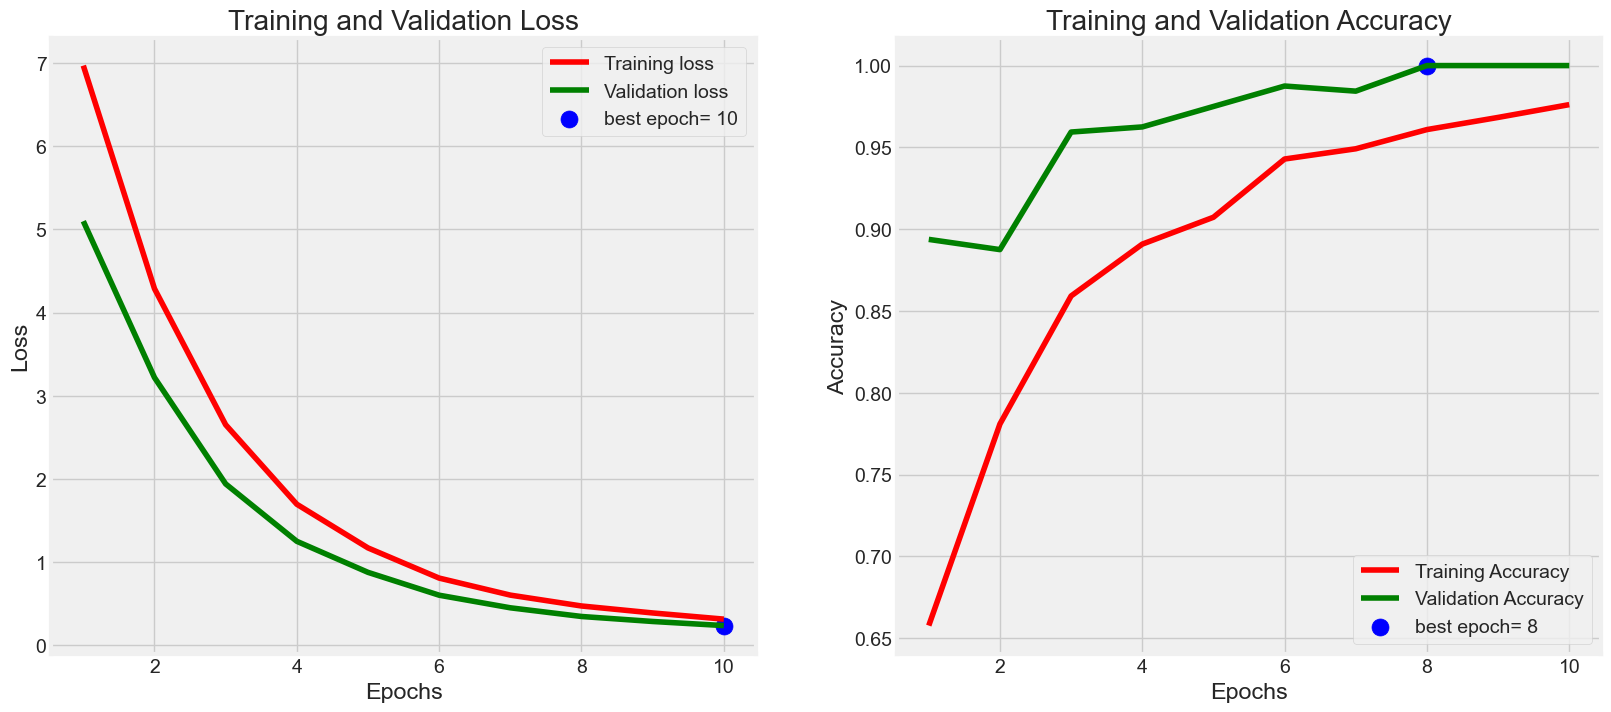

In [ ]:
plot_training(history)

In [ ]:
tamaño_prueba_df = len(prueba_df)
test_tamaño_batch = max(sorted([tamaño_prueba_df // n for n in range(1, tamaño_prueba_df + 1) if tamaño_prueba_df % n == 0 and tamaño_prueba_df / n <= 80]))
test_cant_iteraciones = tamaño_prueba_df // test_tamaño_batch

train_score = model.evaluate(train_gen, steps=test_cant_iteraciones, verbose=1)
valid_score = model.evaluate(valid_gen, steps=test_cant_iteraciones, verbose=1)
test_score = model.evaluate(test_gen, steps=test_cant_iteraciones, verbose=1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])


4/4 [==============================] - 1s 232ms/step - loss: 0.2544 - accuracy: 0.9969
Train Loss:  0.23793751001358032
Train Accuracy:  1.0
--------------------
Validation Loss:  0.23074965178966522
Validation Accuracy:  1.0
--------------------
Test Loss:  0.2543736398220062
Test Accuracy:  0.996874988079071


In [65]:
preds = model.predict_generator(test_gen) #Esta línea utiliza el método predict_generator del modelo para generar predicciones en un conjunto de datos de prueba (test_gen).
y_pred = np.argmax(preds, axis=1) #Esta línea se utiliza para convertir las probabilidades predichas por el modelo en etiquetas de clase. 
# IMPORTANTE : busca el índice de la clase con la mayor probabilidad para cada muestra. y asi clasifica.
print(y_pred)

[0 1 1 0 0 2 1 1 2 0 2 1 0 1 1 2 1 2 2 1 1 0 0 2 2 2 0 0 0 0 0 0 0 0 1 0 2
 0 0 1 2 2 2 0 0 1 0 0 2 2 1 0 2 2 0 2 2 1 0 0 0 2 0 0 0 0 0 2 0 2 1 2 0 0
 2 2 0 0 0 1 1 1 0 0 1 1 2 0 1 2 1 0 1 2 2 0 0 1 1 1 2 2 1 1 2 0 0 0 1 2 0
 0 0 0 2 1 0 0 0 2 2 2 2 0 1 2 0 1 2 1 1 2 2 0 0 0 0 2 1 1 1 1 2 2 2 1 0 0
 0 0 0 0 2 0 0 0 2 0 2 0 2 0 0 1 1 0 2 0 2 1 2 0 1 0 2 1 1 0 1 2 0 0 0 1 0
 0 1 2 2 2 0 2 0 2 1 0 1 0 0 0 0 1 0 0 1 2 1 2 2 0 1 2 1 0 0 2 1 1 0 0 0 1
 1 0 0 1 1 2 0 2 0 2 0 1 0 1 2 0 2 0 0 2 0 1 1 1 0 1 0 0 1 1 2 1 2 0 1 0 0
 0 1 2 0 2 2 0 0 2 1 1 1 0 2 0 2 1 0 1 0 2 0 0 1 1 0 0 2 1 0 0 2 1 1 2 2 1
 2 1 0 2 2 2 1 2 1 1 0 2 1 2 0 2 0 0 1 2 2 1 0 0]


In [67]:
gen_diccionario = test_gen.class_indices
list_etiquetas_imagenes = list(gen_diccionario.keys())
gen_diccionario

{'Deterioro cognitivo ( CI )': 0,
 'Deterioro moderado - severo ( AD )': 1,
 'No deterioro ( CN )': 2}

Matriz de confusión, sin Normalization
[[135   1   0]
 [  0  90   0]
 [  0   0  94]]
                                    precision    recall  f1-score   support

        Deterioro cognitivo ( CI )       1.00      0.99      1.00       136
Deterioro moderado - severo ( AD )       0.99      1.00      0.99        90
               No deterioro ( CN )       1.00      1.00      1.00        94

                          accuracy                           1.00       320
                         macro avg       1.00      1.00      1.00       320
                      weighted avg       1.00      1.00      1.00       320



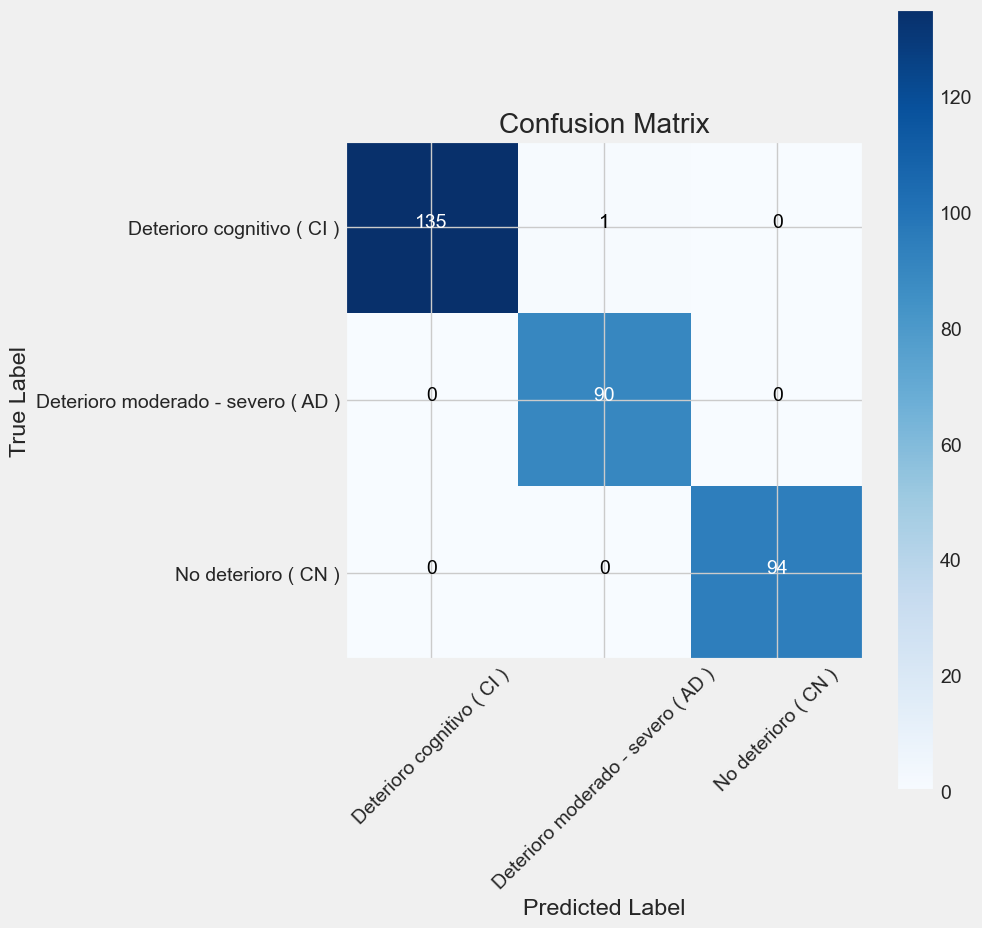

In [ ]:
gen_diccionario = test_gen.class_indices
list_etiquetas_imagenes = list(gen_diccionario.keys())
cm = confusion_matrix(test_gen.classes, y_pred)
plot_confusion_matrix(cm= cm, classes= list_etiquetas_imagenes, title = 'Confusion Matrix')
print(classification_report(test_gen.classes, y_pred, target_names= list_etiquetas_imagenes))

Número de imágenes en el lote: 4
1/1 [==============================] - 0s 23ms/step


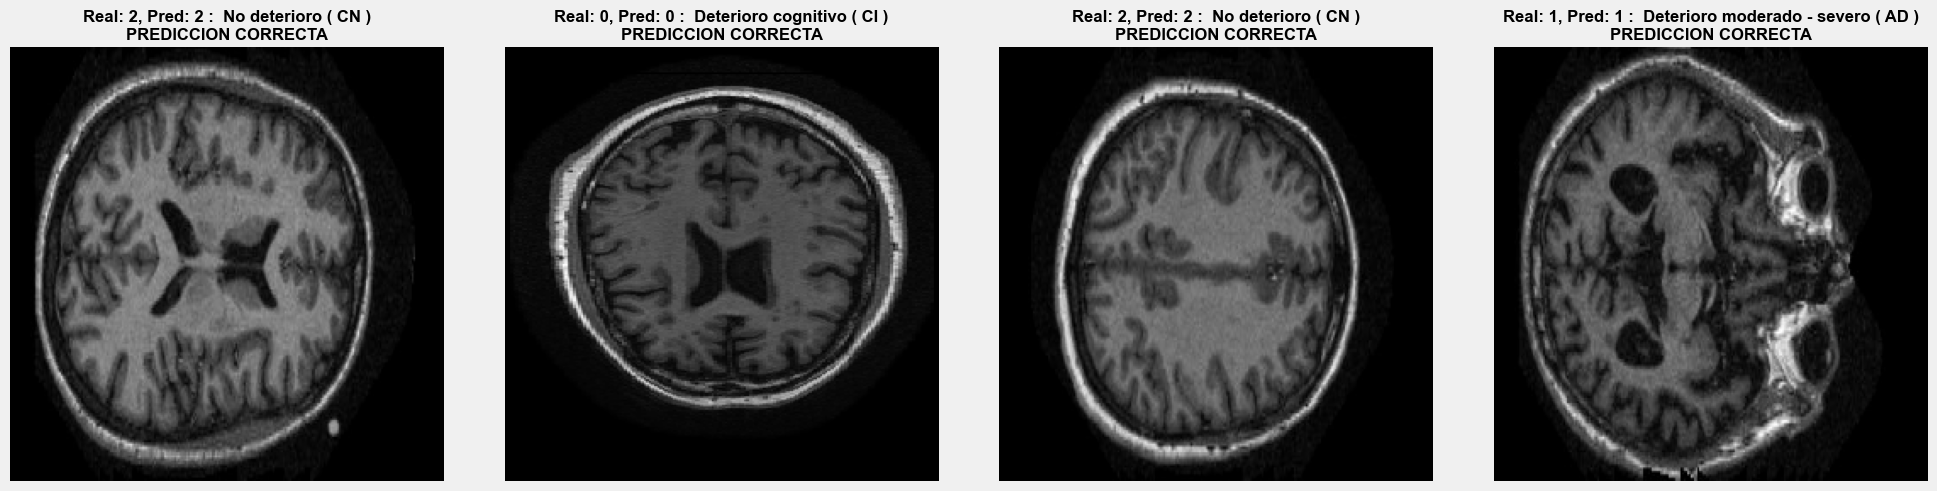

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class_names = ['Deterioro cognitivo ( CI )', 'Deterioro moderado - severo ( AD )', 'No deterioro ( CN )']

batch_images, batch_labels = next(valid_gen)

num_images = len(batch_images)
print(f"Número de imágenes en el lote: {num_images}")

predictions = model.predict(batch_images)

predicted_classes = np.argmax(predictions, axis=1)

fig, axes = plt.subplots(1, min(5, num_images), figsize=(20, 5))

for i in range(min(5, num_images)):
    sin_rotar = batch_images[i]
    axes[i].imshow(sin_rotar / 255.0)
    
    actual_class = np.argmax(batch_labels[i])
    predicted_class = predicted_classes[i]
    nombre_clase_predicha = class_names[predicted_class]

    if actual_class == predicted_class:
        status_text = "PREDICCION CORRECTA"
    else:
        status_text = "PREDICCION INCORRECTA"
    
    axes[i].set_title(f"Real: {actual_class}, Pred: {predicted_class} :  {nombre_clase_predicha}\n{status_text}", 
                      color="black", fontweight="bold", fontsize=12)
    
    axes[i].axis('off')

plt.tight_layout()
plt.show()
